In [ ]:

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import os

from sklearn.metrics import classification_report
import tensorflow.keras.backend as K

In [ ]:
# Config
INPUT_DIR = Path("./output_wav2vec_precomputed_features")
OUTPUT_DIR = Path("./output_1d_cnn_5_class_tpu")
OUTPUT_DIR.mkdir(exist_ok=True)

# Model & Feature Params
MAX_SEQ_LEN = 150
EMBEDDING_DIM = 768
LABEL_COLS = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection']
NUM_CLASSES = len(LABEL_COLS)

# Training Params 
BATCH_SIZE_PER_REPLICA = 16 # Batch size for each TPU core
EPOCHS = 100
LEARNING_RATE = 1e-6
THRESHOLD = 0.5

TRAIN_DATA_PATH = INPUT_DIR / "train_data.npz"
VAL_DATA_PATH = INPUT_DIR / "val_data.npz"
TEST_DATA_PATH = INPUT_DIR / "test_data.npz"
BEST_MODEL_PATH = OUTPUT_DIR / "best_1d_cnn_5_class_model_tpu.keras"

In [ ]:
print("--- Initializing TPU Strategy ---")

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu='local')
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    
    print('TPU successfully initialized. Found TPU: ', tpu.master())
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
    print(f"Global batch size set to: {BATCH_SIZE}")
    print("Number of replicas:", strategy.num_replicas_in_sync)

except Exception as e:
    print(f"⚠️ TPU initialization failed, this is the error: {e}")
    print("Falling back to default strategy (CPU/GPU).")
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA

In [ ]:
print("\n--- Loading and modifying pre-computed data... ---")

# Load the compressed .npz files directly into RAM
train_data = np.load(TRAIN_DATA_PATH)
val_data = np.load(VAL_DATA_PATH)
test_data = np.load(TEST_DATA_PATH)

X_train, y_train_full = train_data['x'], train_data['y']
X_val, y_val_full = val_data['x'], val_data['y']
X_test, y_test_full = test_data['x'], test_data['y']

# Remove the last column ('NoStutter') from the labels
y_train = y_train_full[:, :-1]
y_val = y_val_full[:, :-1]
y_test = y_test_full[:, :-1]

# Filter out samples that now have NO labels
train_indices = np.where(y_train.sum(axis=1) > 0)[0]
val_indices = np.where(y_val.sum(axis=1) > 0)[0]
test_indices = np.where(y_test.sum(axis=1) > 0)[0]

X_train, y_train = X_train[train_indices], y_train[train_indices]
X_val, y_val = X_val[val_indices], y_val[val_indices]
X_test, y_test = X_test[test_indices], y_test[test_indices]

print("Data loaded and modified successfully.")
print(f"New X_train shape: {X_train.shape}")

In [13]:
print("\n--- Verifying final training set distribution after augmentation... ---")

# Convert the y_train numpy array to a pandas DataFrame to easily count labels
final_train_labels_df = pd.DataFrame(y_train, columns=LABEL_COLS)

print("Final distribution of labels in the training set (including augmented samples):")
print(final_train_labels_df.sum().sort_values(ascending=False))


--- Verifying final training set distribution after augmentation... ---
Final distribution of labels in the training set (including augmented samples):
Block           12026
Interjection     9173
WordRep          8256
SoundRep         7776
Prolongation     7501
dtype: int64


In [ ]:
def prepare_dataset(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=2048)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = prepare_dataset(X_train, y_train, shuffle=True)
val_dataset = prepare_dataset(X_val, y_val)
test_dataset = prepare_dataset(X_test, y_test)
print("Datasets created successfully.")

In [ ]:
with strategy.scope():
    print("\n--- Building 1D CNN Model inside TPU Strategy Scope... ---")

    def build_cnn_classifier(input_shape, num_classes):
        inputs = tf.keras.layers.Input(shape=input_shape)

        x = tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding="same", activation="relu")(inputs)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)

        x = tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding="same", activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.GlobalAveragePooling1D()(x)

        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6, clipnorm=1.0)
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc', multi_label=True)
            ]
        )
        return model

    model = build_cnn_classifier(input_shape=(MAX_SEQ_LEN, EMBEDDING_DIM), num_classes=NUM_CLASSES)

model.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor='val_auc', mode='max', save_best_only=True, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)


--- Building 1D CNN Model inside TPU Strategy Scope... ---


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 150, 768)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 150, 128)       │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 150, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 75, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 75, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 428,677 (1.64 MB)

 Trainable params: 427,909 (1.63 MB)

 Non-trainable params: 768 (3.00 KB)

In [18]:
print("\n--- Starting Training on TPU... ---")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint, early_stopping]
)


--- Starting Training on TPU... ---
Epoch 1/50


I0000 00:00:1753101294.183301    3938 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:7365665932649420518
I0000 00:00:1753101294.783649    4738 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(5538528863690633013), session_name()
I0000 00:00:1753101297.253188    4738 tpu_compile_op_common.cc:245] Compilation of 5538528863690633013 with session name  took 2.469456662s and succeeded
I0000 00:00:1753101297.264285    4738 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(5538528863690633013), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_7365665932649420518", property.function_library_fingerprint = 3329425672150254958, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z =

173/176 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2009 - auc: 0.5190 - loss: 0.7137 - precision: 0.3933 - recall: 0.4156

I0000 00:00:1753101302.911528    4743 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(13298112271068119697), session_name()
I0000 00:00:1753101305.612761    4743 tpu_compile_op_common.cc:245] Compilation of 13298112271068119697 with session name  took 2.701172821s and succeeded
I0000 00:00:1753101305.623409    4743 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(13298112271068119697), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_7365665932649420518", property.function_library_fingerprint = 3329425672150254958, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "7,150,768,;7,5,;", property.guaranteed_constants_size = 0, embedding_pa

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2009 - auc: 0.5190 - loss: 0.7137 - precision: 0.3934 - recall: 0.4159

I0000 00:00:1753101319.289251    3938 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:2245584714441830754
I0000 00:00:1753101319.702452    4710 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(16381854032987314425), session_name()
I0000 00:00:1753101320.482423    4710 tpu_compile_op_common.cc:245] Compilation of 16381854032987314425 with session name  took 779.89841ms and succeeded
I0000 00:00:1753101320.485742    4710 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(16381854032987314425), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_2245584714441830754", property.function_library_fingerprint = 14724387219674407463, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().


Epoch 1: val_auc improved from -inf to 0.52960, saving model to output_1d_cnn_5_class_tpu/best_1d_cnn_5_class_model_tpu.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 39s 139ms/step - accuracy: 0.2009 - auc: 0.5190 - loss: 0.7137 - precision: 0.3935 - recall: 0.4160 - val_accuracy: 0.0962 - val_auc: 0.5296 - val_loss: 0.7324 - val_precision: 0.4039 - val_recall: 0.8559
Epoch 2/50
175/176 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2168 - auc: 0.5362 - loss: 0.7051 - precision: 0.4129 - recall: 0.4358
Epoch 2: val_auc improved from 0.52960 to 0.55242, saving model to output_1d_cnn_5_class_tpu/best_1d_cnn_5_class_model_tpu.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - accuracy: 0.2167 - auc: 0.5361 - loss: 0.7051 - precision: 0.4129 - recall: 0.4358 - val_accuracy: 0.1625 - val_auc: 0.5524 - val_loss: 0.7124 - val_precision: 0.4093 - val_recall: 0.7810
Epoch 3/50
174/176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2147 - auc: 0.5427 - loss: 0.7002 - precision: 0.4181 - recall: 0.4368


In [ ]:
TOTAL_EPOCHS = 150
initial_epoch = history.epoch[-1] + 1

print(f"Continuing training from epoch {initial_epoch} up to {TOTAL_EPOCHS}...")

new_history = model.fit(
    train_dataset,
    epochs=TOTAL_EPOCHS,
    initial_epoch=initial_epoch,
    validation_data=val_dataset,
    callbacks=[checkpoint, early_stopping]
)

Continuing training from epoch 50 up to 150...
Epoch 51/150
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2958 - auc: 0.6512 - loss: 0.6335 - precision: 0.5681 - recall: 0.4472
Epoch 51: val_auc improved from 0.68188 to 0.68193, saving model to output_1d_cnn_5_class_tpu/best_1d_cnn_5_class_model_tpu.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - accuracy: 0.2957 - auc: 0.6512 - loss: 0.6335 - precision: 0.5681 - recall: 0.4472 - val_accuracy: 0.2429 - val_auc: 0.6819 - val_loss: 0.6196 - val_precision: 0.5940 - val_recall: 0.4807
Epoch 52/150
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2954 - auc: 0.6613 - loss: 0.6247 - precision: 0.5594 - recall: 0.4355
Epoch 52: val_auc improved from 0.68193 to 0.68290, saving model to output_1d_cnn_5_class_tpu/best_1d_cnn_5_class_model_tpu.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 29s 106ms/step - accuracy: 0.2953 - auc: 0.6613 - loss: 0.6247 - precision: 0.5594 - recall: 0.4356 - val_accuracy: 0.2492 - val_auc: 0.6829 - val_los

In [ ]:
TOTAL_EPOCHS = 400
initial_epoch = new_history.epoch[-1] + 1

print(f"Continuing training from epoch {initial_epoch} up to {TOTAL_EPOCHS}...")

new_history2 = model.fit(
    train_dataset,
    epochs=TOTAL_EPOCHS,
    initial_epoch=initial_epoch, 
    validation_data=val_dataset,
    callbacks=[checkpoint, early_stopping]
)

Continuing training from epoch 150 up to 400...
Epoch 151/400
174/176 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3450 - auc: 0.7017 - loss: 0.6004 - precision: 0.6231 - recall: 0.4766
Epoch 151: val_auc did not improve from 0.70867
176/176 ━━━━━━━━━━━━━━━━━━━━ 30s 114ms/step - accuracy: 0.3449 - auc: 0.7017 - loss: 0.6003 - precision: 0.6232 - recall: 0.4769 - val_accuracy: 0.2934 - val_auc: 0.7087 - val_loss: 0.5987 - val_precision: 0.6072 - val_recall: 0.5153
Epoch 152/400
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3240 - auc: 0.6896 - loss: 0.6042 - precision: 0.6193 - recall: 0.4782
Epoch 152: val_auc improved from 0.70867 to 0.70918, saving model to output_1d_cnn_5_class_tpu/best_1d_cnn_5_class_model_tpu.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 30s 112ms/step - accuracy: 0.3240 - auc: 0.6897 - loss: 0.6042 - precision: 0.6193 - recall: 0.4783 - val_accuracy: 0.2902 - val_auc: 0.7092 - val_loss: 0.5979 - val_precision: 0.6112 - val_recall: 0.5201
Epoch 153/400
175/176 ━


--- Evaluating Model on the Test Set ---


I0000 00:00:1753100882.723564    3938 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:14168895439791745766
E0000 00:00:1753100882.733558    3938 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1_1/batch_normalization_2_1/Cast/ReadVariableOp.
I0000 00:00:1753100882.772372    4726 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(3955853719832996069), session_name()
I0000 00:00:1753100883.031795    4726 tpu_compile_op_common.cc:245] Compilation of 3955853719832996069 with session name  took 259.353448ms and succeeded
I0000 00:00:1753100883.032985    4726 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(3955853719832996069), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_14168895439791745766", property.function_library_fingerprint = 10667233458004801588, property.mlir_mo

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step

I0000 00:00:1753100887.647196    3938 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:12140649142079556011
I0000 00:00:1753100887.840760    4666 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(18164971116944237923), session_name()
I0000 00:00:1753100888.312018    4666 tpu_compile_op_common.cc:245] Compilation of 18164971116944237923 with session name  took 471.212601ms and succeeded
I0000 00:00:1753100888.312792    4666 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(18164971116944237923), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_12140649142079556011", property.function_library_fingerprint = 303911995334612792, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, top

55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.84      0.21      0.34      2613
       Block       0.62      0.44      0.51      3501
    SoundRep       0.65      0.37      0.47      1891
     WordRep       0.38      0.79      0.51      1742
Interjection       0.71      0.80      0.75      3344

   micro avg       0.59      0.52      0.55     13091
   macro avg       0.64      0.52      0.52     13091
weighted avg       0.66      0.52      0.53     13091
 samples avg       0.56      0.53      0.51     13091


--- Generating plots for model training history... ---


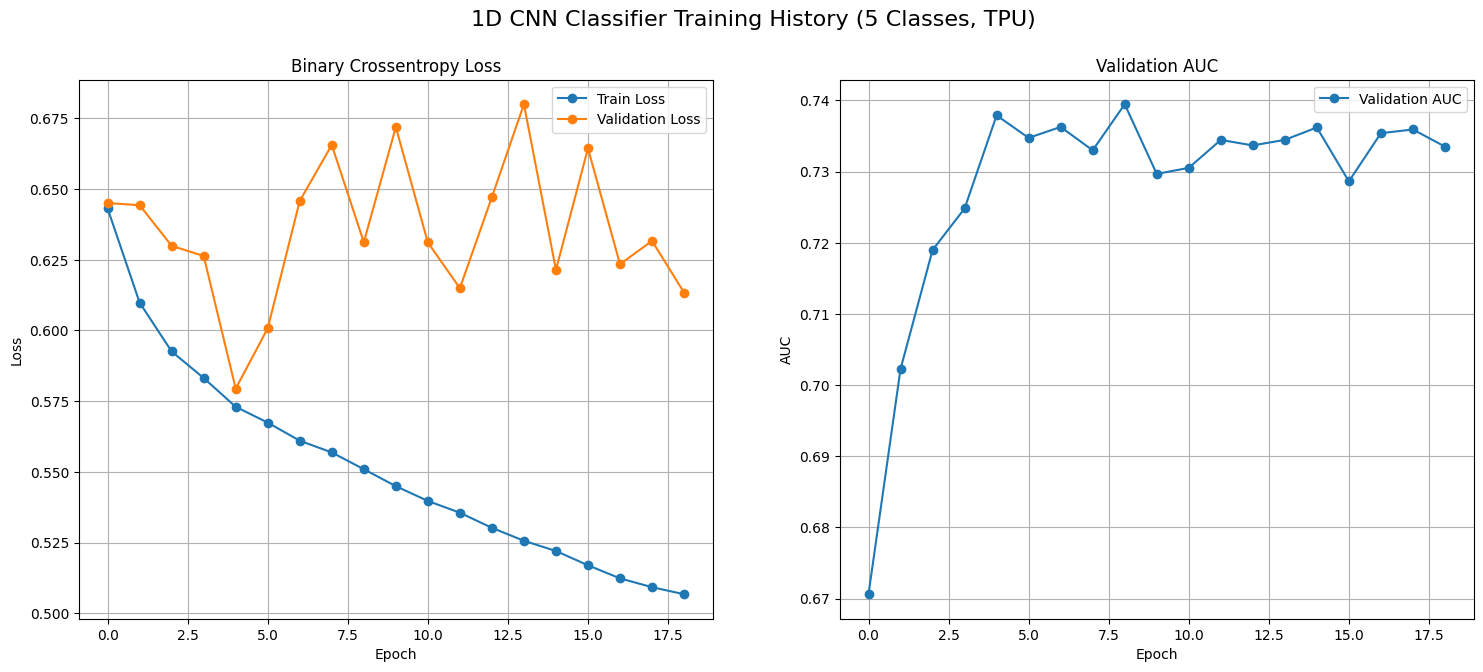


--- Pipeline complete. All outputs saved in 'output_1d_cnn_5_class_tpu' directory. ---


In [ ]:
# LR = 1e-4
print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred)
report = classification_report(y_test[:num_predictions], y_pred, target_names=LABEL_COLS, zero_division=0)
print("\n--- Classification Report (5 Stuttering Classes) ---")
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

# Plotting History 
print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('1D CNN Classifier Training History (5 Classes, TPU)', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history_1d_cnn_5_class_tpu.png")
plt.show()

print(f"\n--- Pipeline complete. All outputs saved in '{OUTPUT_DIR}' directory. ---")


--- Evaluating Model on the Test Set ---


I0000 00:00:1753102740.893078    3938 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:13921049038909228598
E0000 00:00:1753102740.905428    3938 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_2_1/batch_normalization_4_1/Cast/ReadVariableOp.
I0000 00:00:1753102740.957020    4721 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(5193316772026586782), session_name()
I0000 00:00:1753102741.214524    4721 tpu_compile_op_common.cc:245] Compilation of 5193316772026586782 with session name  took 257.415565ms and succeeded
I0000 00:00:1753102741.215598    4721 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(5193316772026586782), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_13921049038909228598", property.function_library_fingerprint = 13506779652691662966, property.mlir_mo

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step

I0000 00:00:1753102745.887103    3938 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:8859412421014921869
I0000 00:00:1753102746.009450    4734 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(13557254380347804653), session_name()
I0000 00:00:1753102746.485751    4734 tpu_compile_op_common.cc:245] Compilation of 13557254380347804653 with session name  took 476.255849ms and succeeded
I0000 00:00:1753102746.486538    4734 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(13557254380347804653), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_8859412421014921869", property.function_library_fingerprint = 15187189124008374559, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, top

55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.65      0.25      0.36      2613
       Block       0.61      0.46      0.53      3501
    SoundRep       0.56      0.39      0.46      1891
     WordRep       0.46      0.30      0.36      1742
Interjection       0.76      0.53      0.62      3344

   micro avg       0.63      0.41      0.49     13091
   macro avg       0.61      0.39      0.47     13091
weighted avg       0.63      0.41      0.49     13091
 samples avg       0.48      0.40      0.41     13091


--- Generating plots for model training history... ---


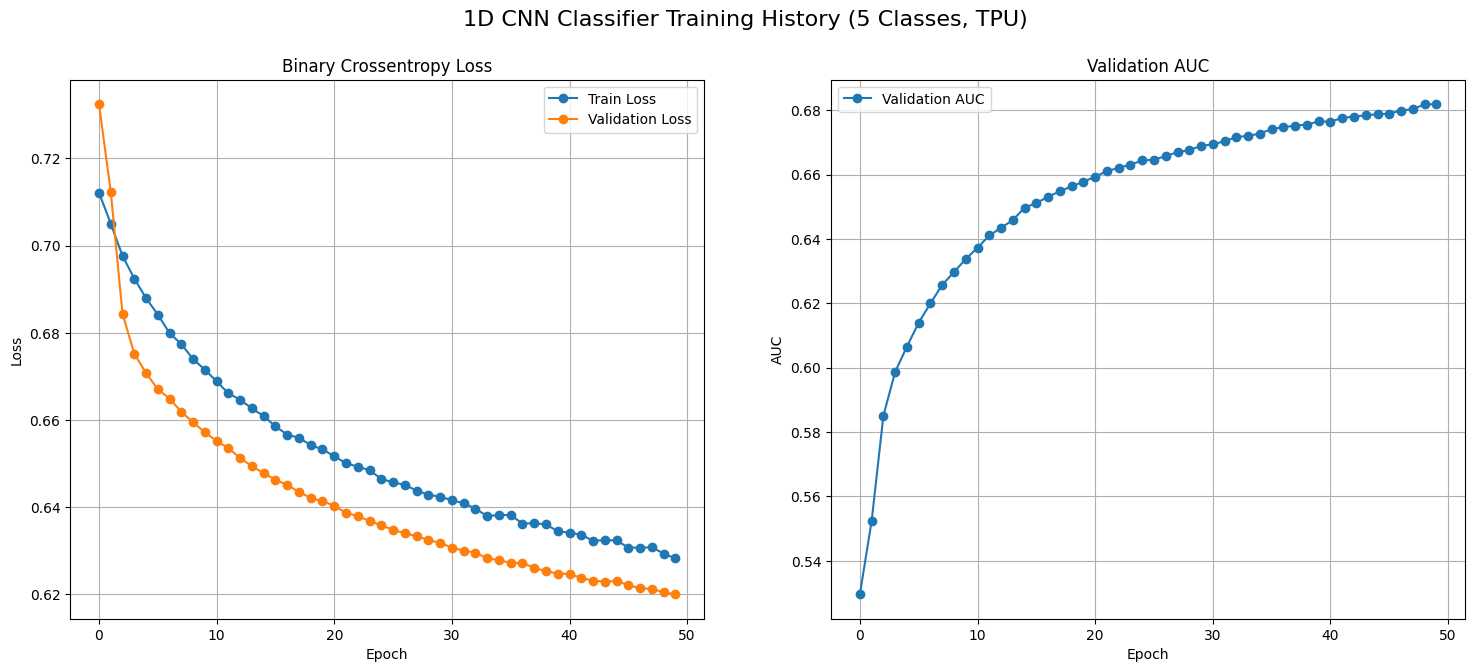


--- Pipeline complete. All outputs saved in 'output_1d_cnn_5_class_tpu' directory. ---


In [ ]:
# LR = 1e-6
print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred)
report = classification_report(y_test[:num_predictions], y_pred, target_names=LABEL_COLS, zero_division=0)
print("\n--- Classification Report (5 Stuttering Classes) ---")
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

# --- Plotting History ---
print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('1D CNN Classifier Training History (5 Classes, TPU)', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history_1d_cnn_5_class_tpu.png")
plt.show()

print(f"\n--- Pipeline complete. All outputs saved in '{OUTPUT_DIR}' directory. ---")


--- Generating plots for the full combined training history... ---


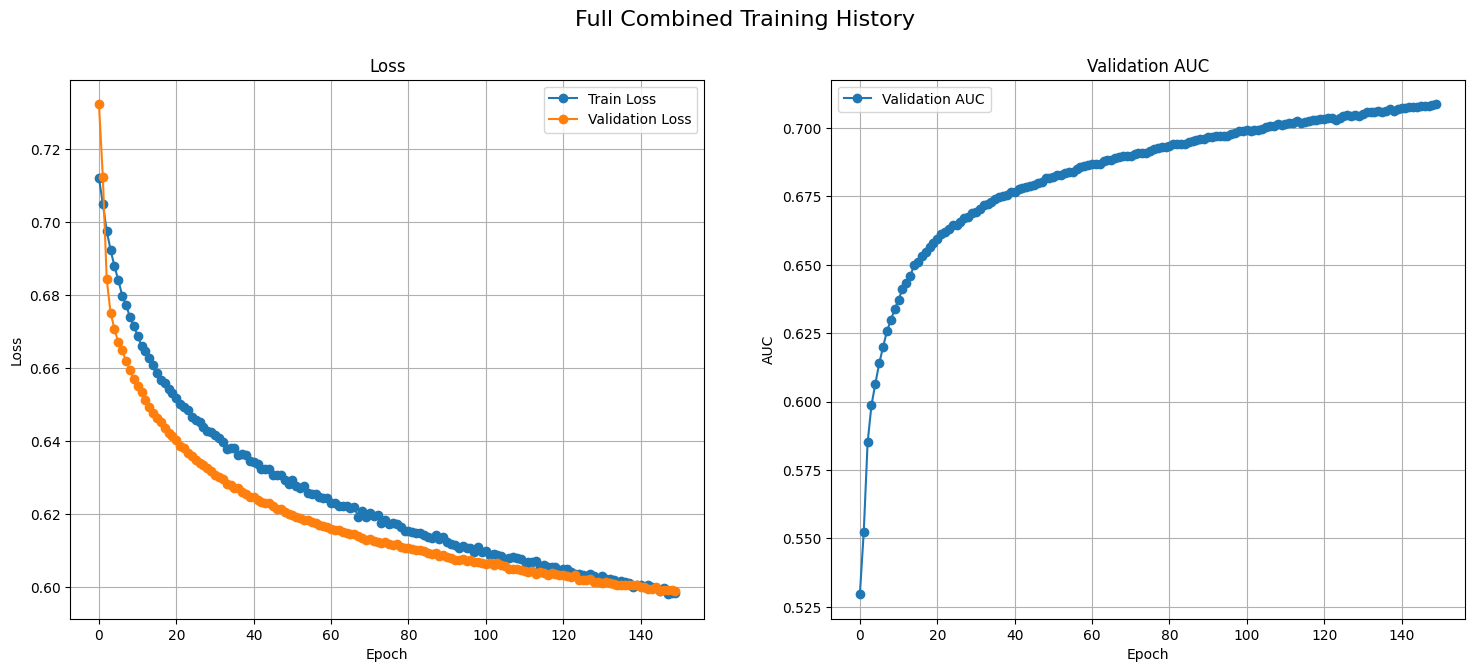


--- Final Evaluation after Extended Training ---
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step

--- Final Classification Report ---
              precision    recall  f1-score   support

Prolongation       0.71      0.31      0.43      2613
       Block       0.59      0.61      0.60      3501
    SoundRep       0.60      0.39      0.47      1891
     WordRep       0.51      0.34      0.41      1742
Interjection       0.83      0.52      0.64      3344

   micro avg       0.65      0.46      0.54     13091
   macro avg       0.65      0.43      0.51     13091
weighted avg       0.67      0.46      0.53     13091
 samples avg       0.56      0.46      0.48     13091



In [ ]:
# LR = 1e-6 contd.
# Manually merges the history dictionaries to create a complete record.
for key in history.history:
    history.history[key].extend(new_history.history[key])

print("\n--- Generating plots for the full combined training history... ---")
history_dict = history.history 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Full Combined Training History', fontsize=16)

# Plot Loss
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)

# Plot AUC
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)

plt.savefig(OUTPUT_DIR / "full_training_history.png")
plt.show()
 
print("\n--- Final Evaluation after Extended Training ---")
y_pred_probs = model.predict(test_dataset)
y_pred = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred)
report = classification_report(y_test[:num_predictions], y_pred, target_names=LABEL_COLS, zero_division=0)
print("\n--- Final Classification Report ---")
print(report)


--- Generating plots for the full combined training history... ---


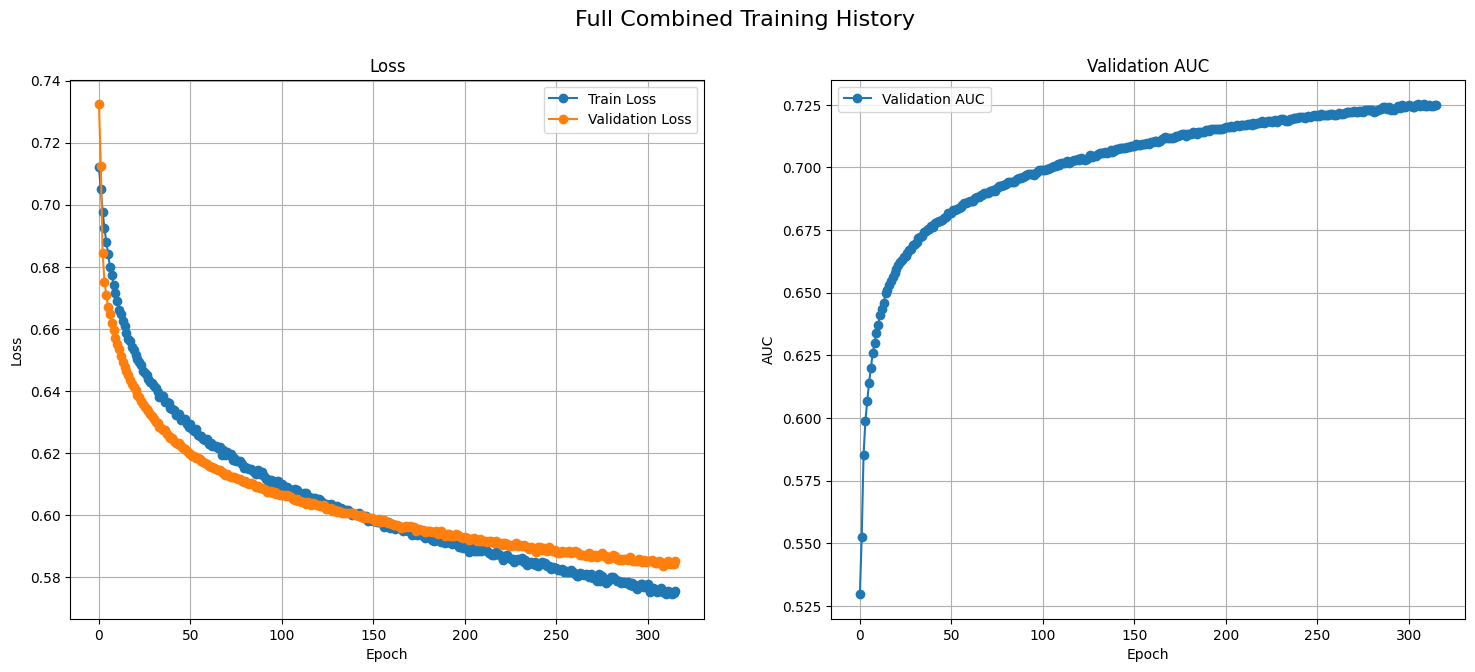

55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step

--- Final Classification Report ---
              precision    recall  f1-score   support

Prolongation       0.71      0.36      0.48      2613
       Block       0.59      0.65      0.62      3501
    SoundRep       0.64      0.38      0.48      1891
     WordRep       0.53      0.33      0.41      1742
Interjection       0.84      0.55      0.67      3344

   micro avg       0.66      0.49      0.56     13091
   macro avg       0.66      0.46      0.53     13091
weighted avg       0.68      0.49      0.56     13091
 samples avg       0.59      0.50      0.51     13091



In [ ]:
# LR = 1e-6 contd.
for key in history.history:
    history.history[key].extend(new_history2.history[key])

print("\n--- Generating plots for the full combined training history... ---")
history_dict = history.history # Now contains the full history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Full Combined Training History', fontsize=16)

# Plot Loss
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)

# Plot AUC
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)


plt.show()


y_pred_probs = model.predict(test_dataset)
y_pred = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred)
report = classification_report(y_test[:num_predictions], y_pred, target_names=LABEL_COLS, zero_division=0)
print("\n--- Final Classification Report ---")
print(report)